In [17]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
from astropy.constants import G, c, M_sun, hbar
import astropy.units as u
from scipy.optimize import fsolve


plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


# Dark matter

Dimensionless

$$

p'' = \frac{p}{m_f^4} \qquad \epsilon'' = \frac{\epsilon}{m_f^4}  \qquad  M'' =  \frac{M}{a} \qquad R'' =  \frac{R}{b}, \qquad a =  \frac{M_p^3}{m_f^2}, \qquad b = \frac{M_p}{m_f^2}
$$
$$

p' =p'' \frac{m_f^4}{4B} \qquad \epsilon' = \epsilon''\frac{m_f^4}{4B}
$$

# Quark matter


EoS MIT Bag Model

$$
p = \frac{1}{3}(\epsilon - 4 B)
$$

Dimensionless

$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad  M' = 2\sqrt{B} \frac{M}{M_p^3} \qquad R' = 2\sqrt{B} \frac{R}{M_p}
$$
$$
p' = \frac{1}{3}(\epsilon' - 1)
$$


In [18]:
# open a data file
data = pd.read_csv('../Data/EOS_QM.csv')

# Extract columns
grid_e_quark = data['e']
grid_p_quark = data['p']


data = pd.read_csv('../Data/EOS_DM_mf1e3.csv')

# Extract columns
grid_e_dm = data['e']
grid_p_dm = data['p']

Two fluid

In [19]:
def compute_two_fluid_properties(e_quark, p_quark, e_dm, p_dm, r0=1e-6):

    # 1. Initial Conditions Calculation
    # ---------------------------------

    
    # Quark Matter ICs
    m_quark_c = (4/3) * np.pi * r0**3 * e_quark
    
    # Dark Matter ICs
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm
    
    x0 = [p_quark, m_quark_c, p_dm, m_dm_c]

    # 2. Define ODE (Nested to capture global EoS)
    # --------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x
        
        # Sanitize inputs
        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        # Get Energy Densities
        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0
            
        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_dm, grid_e_dm)
        else:
            e2 = 0.0
        
        M = M1 + M2

        # Singularity check
        if r < 1e-9:
            return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

        # Metric terms
        term1_q = (e1 + p1_phys)
        term1_dm = (e2 + p2_phys)
        term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
        term3 = 1 - 2 * M / r

        # Horizon check
        if term3 <= 1e-9:
            return [0, 0, 0, 0]

        factor = - (M / r**2) / term3

        # Fluid 1 Derivatives (Quark)
        if p1 <= 0:
            dp1dr, dM1dr = -1.0, 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4 * np.pi * r**2 * e1

        # Fluid 2 Derivatives (DM)
        if p2 <= 0:
            dp2dr, dM2dr = -1.0, 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # 3. Events 
    # ----------------------------------------------------

    # Event Quark Surface (do not stop)
    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = False 
    event_Quark_surface.direction = -1

    # Event DM Surface (do not stop)
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    # Event C: Stop Integration
    def event_Stop_Integration(r, x):
        return max(x[0], x[2])
    event_Stop_Integration.terminal = True
    event_Stop_Integration.direction = -1

    # 4. Run Solver
    # -------------
    sol = solve_ivp(
        ode_TOV, 
        (r0, 1e12), 
        x0, 
        events=[event_DM_surface, event_Quark_surface, event_Stop_Integration],
        rtol=1e-8, 
        atol=1e-10,
        first_step=1e-7
    )

    r_adim = sol.t.copy()
    p1_adim = sol.y[0].copy()
    m1_adim = sol.y[1].copy()
    p2_adim = sol.y[2].copy()
    m2_adim = sol.y[3].copy()

    # --- EXTRACT EXACT RADII FROM EVENTS ---
    # sol.t_events is a list containing the R values for each event function.
    # Index [0] corresponds to event_Quark_surface
    # Index [1] corresponds to event_DM_surface

    # 1. Quark Matter Handling
    if len(sol.t_events[0]) > 0:
        R_quark_final = sol.t_events[0][0] # Take the first crossing
        print(f"Quark Surface detected at R = {R_quark_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        # This replaces the manual index search
        p1_adim[r_adim > R_quark_final] = 0.0
    else:
        R_quark_final = None
        print("Quark pressure never crossed zero (or started at 0).")

    # 2. Dark Matter Handling
    if len(sol.t_events[1]) > 0:
        R_DM_final = sol.t_events[1][0] # Take the first crossing
        print(f"DM Surface detected at R = {R_DM_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        p2_adim[r_adim > R_DM_final] = 0.0
    else:
        R_DM_final = None
        print("DM pressure never crossed zero (or started at 0).")

    # 6. Physical Conversions
    # -----------------------
    M_p = 1.2209e22  # MeV
    mev_to_kg = 1.78266192e-30 
    msun_kg = 1.98847e30
    B = 145**4  # MeV^4
    hc = 197.3269804  # MeV*fm
    
    factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
    factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
    factor_P_to_MeV4 = 4 * B


    R_km = r_adim * factor_R_to_km
    P1_phys = p1_adim * factor_P_to_MeV4
    M1_phys = m1_adim * factor_M_to_Solar
    P2_phys = p2_adim * factor_P_to_MeV4
    M2_phys = m2_adim * factor_M_to_Solar

    M_total = M1_phys + M2_phys

    results = {
        "R_quark": R_quark_final * factor_R_to_km,
        "R_dm": R_DM_final * factor_R_to_km ,
        "M_total": M_total[-1]
    }
    return results


In [20]:
hc = 197.3269804  # MeV*fm
B = 145**4  # MeV^4


M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30
B = 145**4  # MeV^4
hc = 197.3269804  # MeV*fm
    
factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B

e_quark_central = 1000 * hc**3 / (4 * B) 
e_dm_central    = 3e6 * hc**3 / (4 * B) 
p_quark_central = np.interp(e_quark_central, grid_e_quark, grid_p_quark)
p_dm_central    = np.interp(e_dm_central, grid_e_dm, grid_p_dm)


data = compute_two_fluid_properties(e_quark_central,p_quark_central, e_dm_central,p_dm_central)

print(f"Quark Star: R = {data['R_quark']:.4f} km")
print(f"DM Core:    R = {data['R_dm']:.4f} km")
print(f"Total Mass: M = {data['M_total']:.4f} M_sun")

Quark Surface detected at R = 7.6156e-02
DM Surface detected at R = 1.7789e-02
Quark Star: R = 4.3632 km
DM Core:    R = 1.0192 km
Total Mass: M = 0.3694 M_sun


# Ratio

$$
R = \frac{p_{DM}}{p_{QM}}
$$

In [21]:
def compute_two_fluid_properties_ratio(e_quark, p_quark, R, r0=1e-6):

    # 1. Initial Conditions Calculation
    # ---------------------------------

    
    # Quark Matter ICs
    m_quark_c = (4/3) * np.pi * r0**3 * e_quark
    
    # Dark Matter ICs
    p_dm = p_quark * R
    e_dm = np.interp(p_dm, grid_p_dm, grid_e_dm)
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm
    
    x0 = [p_quark, m_quark_c, p_dm, m_dm_c]

    # 2. Define ODE (Nested to capture global EoS)
    # --------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x
        
        # Sanitize inputs
        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        # Get Energy Densities
        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0
            
        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_dm, grid_e_dm)
        else:
            e2 = 0.0
        
        M = M1 + M2

        # Singularity check
        if r < 1e-9:
            return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

        # Metric terms
        term1_q = (e1 + p1_phys)
        term1_dm = (e2 + p2_phys)
        term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
        term3 = 1 - 2 * M / r

        # Horizon check
        if term3 <= 1e-9:
            return [0, 0, 0, 0]

        factor = - (M / r**2) / term3

        # Fluid 1 Derivatives (Quark)
        if p1 <= 0:
            dp1dr, dM1dr = -1.0, 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4 * np.pi * r**2 * e1

        # Fluid 2 Derivatives (DM)
        if p2 <= 0:
            dp2dr, dM2dr = -1.0, 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # 3. Events 
    # ----------------------------------------------------

    # Event Quark Surface (do not stop)
    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = False 
    event_Quark_surface.direction = -1

    # Event DM Surface (do not stop)
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    # Event C: Stop Integration
    def event_Stop_Integration(r, x):
        return max(x[0], x[2])
    event_Stop_Integration.terminal = True
    event_Stop_Integration.direction = -1

    # 4. Run Solver
    # -------------
    sol = solve_ivp(
        ode_TOV, 
        (r0, 1e12), 
        x0, 
        events=[event_Quark_surface, event_DM_surface,  event_Stop_Integration],
        rtol=1e-8, 
        atol=1e-10,
        first_step=1e-7
    )

    r_adim = sol.t.copy()
    p1_adim = sol.y[0].copy()
    m1_adim = sol.y[1].copy()
    p2_adim = sol.y[2].copy()
    m2_adim = sol.y[3].copy()

    # --- EXTRACT EXACT RADII FROM EVENTS ---
    # sol.t_events is a list containing the R values for each event function.
    # Index [0] corresponds to event_Quark_surface
    # Index [1] corresponds to event_DM_surface

    # 1. Quark Matter Handling
    if len(sol.t_events[0]) > 0:
        R_quark_final = sol.t_events[0][0] # Take the first crossing
        #print(f"Quark Surface detected at R = {R_quark_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        # This replaces the manual index search
        p1_adim[r_adim > R_quark_final] = 0.0
    else:
        R_quark_final = None
        print("Quark pressure never crossed zero (or started at 0).")

    # 2. Dark Matter Handling
    if len(sol.t_events[1]) > 0:
        R_DM_final = sol.t_events[1][0] # Take the first crossing
        #print(f"DM Surface detected at R = {R_DM_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        p2_adim[r_adim > R_DM_final] = 0.0
    else:
        R_DM_final = None
        print("DM pressure never crossed zero (or started at 0).")


    R_km = r_adim * factor_R_to_km
    P1_phys = p1_adim * factor_P_to_MeV4
    M1_phys = m1_adim * factor_M_to_Solar
    P2_phys = p2_adim * factor_P_to_MeV4
    M2_phys = m2_adim * factor_M_to_Solar

    M_total = M1_phys + M2_phys

    results = {
        "R_quark": R_quark_final * factor_R_to_km,
        "R_dm": R_DM_final * factor_R_to_km ,
        "M_total": M_total[-1],
        "M_quark": M1_phys[-1],
        "M_dm": M2_phys[-1]
    }
    return results


In [22]:
central_energy_densities_phys = np.linspace(250,1e4,200) # MeV/fm^3

central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_quark, grid_p_quark)

list_Rqm_1e_6 = []
list_Rdm_1e_6 = []
list_M_1e_6 = []
list_Mqm_1e_6 = []
list_Mdm_1e_6 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=1e-6)
    list_Rqm_1e_6.append(data['R_quark'])
    list_Rdm_1e_6.append(data['R_dm'])
    list_M_1e_6.append(data['M_total'])
    list_Mqm_1e_6.append(data['M_quark'])
    list_Mdm_1e_6.append(data['M_dm'])


list_Rqm_1 = []
list_Rdm_1 = []
list_M_1 = []
list_Mqm_1 = []
list_Mdm_1 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=1)
    list_Rqm_1.append(data['R_quark'])
    list_Rdm_1.append(data['R_dm'])
    list_M_1.append(data['M_total'])
    list_Mqm_1.append(data['M_quark'])
    list_Mdm_1.append(data['M_dm'])

list_Rqm_100 = []
list_Rdm_100 = []
list_M_100 = []
list_Mqm_100 = []
list_Mdm_100 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=100)
    list_Rqm_100.append(data['R_quark'])
    list_Rdm_100.append(data['R_dm'])
    list_M_100.append(data['M_total'])
    list_Mqm_100.append(data['M_quark'])
    list_Mdm_100.append(data['M_dm'])


list_Rqm_0 = []
list_Rdm_0 = []
list_M_0 = []
list_Mqm_0 = []
list_Mdm_0 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=0)
    list_Rqm_0.append(data['R_quark'])
    list_Rdm_0.append(data['R_dm'])
    list_M_0.append(data['M_total'])
    list_Mqm_0.append(data['M_quark'])
    list_Mdm_0.append(data['M_dm'])

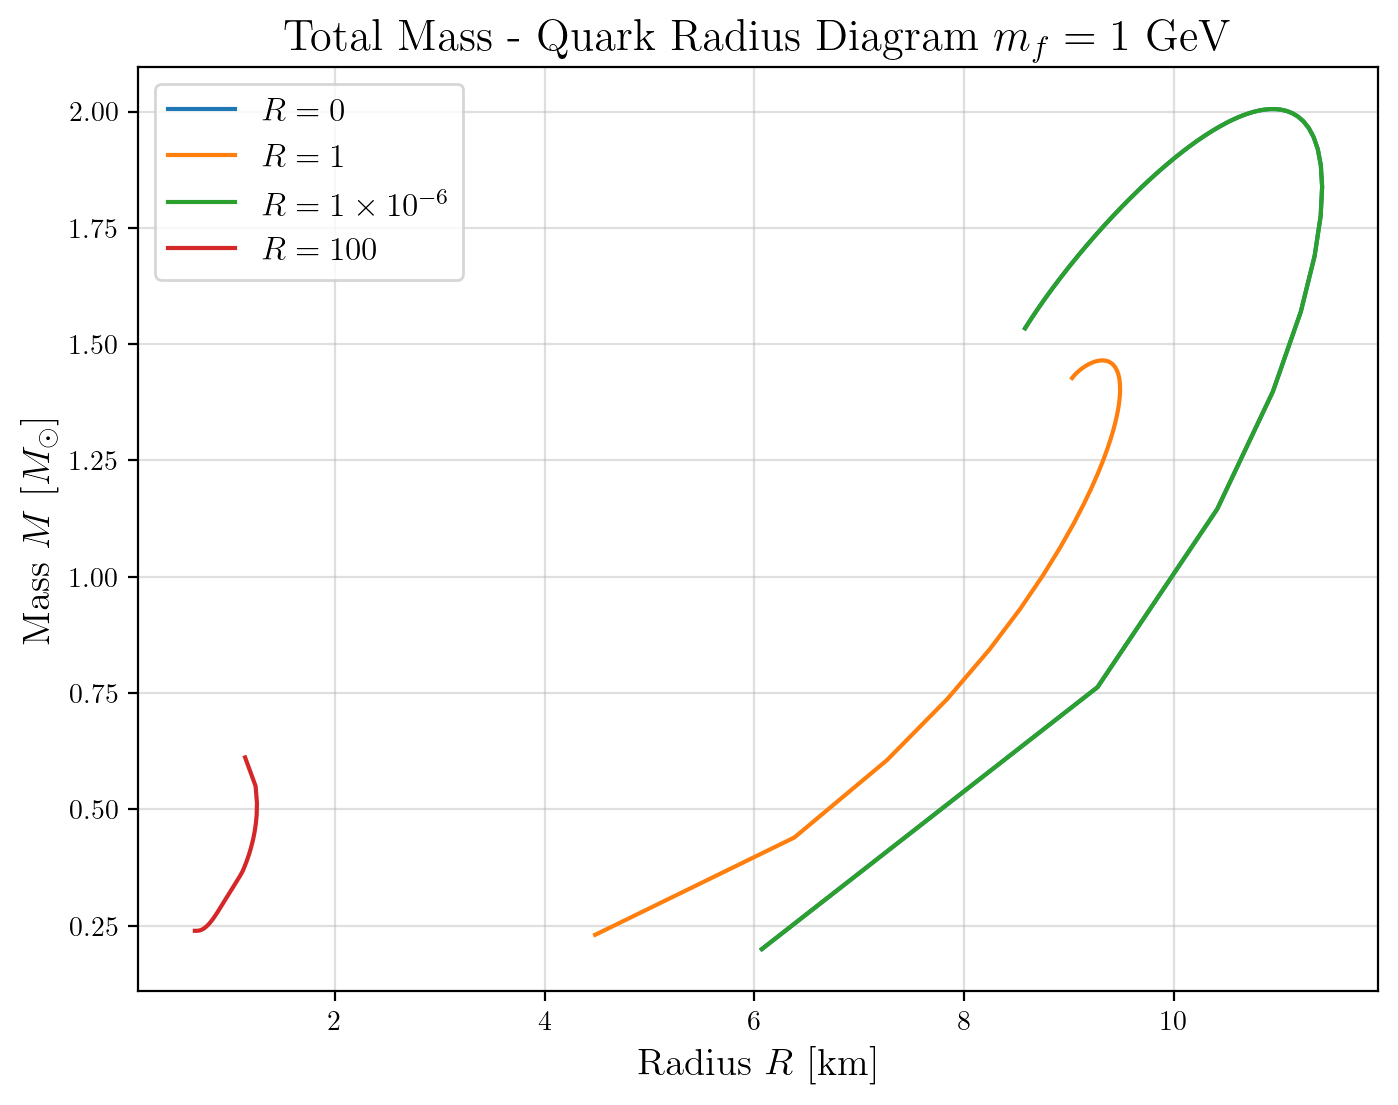

In [23]:
#plot Mass-Radius Diagram
plt.figure(figsize=(8,6))

plt.plot(list_Rqm_0, list_M_0, label=r'$R = 0$')
plt.plot(list_Rqm_1, list_M_1, label=r'$R = 1$')
plt.plot(list_Rqm_1e_6, list_M_1e_6, label=r'$R = 1 \times 10^{-6}$')
plt.plot(list_Rqm_100, list_M_100, label=r'$R = 100$')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'Radius $R$ [km]', fontsize=14)
plt.ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
plt.title('Total Mass - Quark Radius Diagram $m_f =1 $ GeV', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

I would like to compare with the solutions of only quark, can i get the csv and just plot it here. 

After doing it i realize the code for R=0 is not giving the same results, it was because the events orther was mixed, i was reading quark radius as dm radius. Now it is giving the same results.

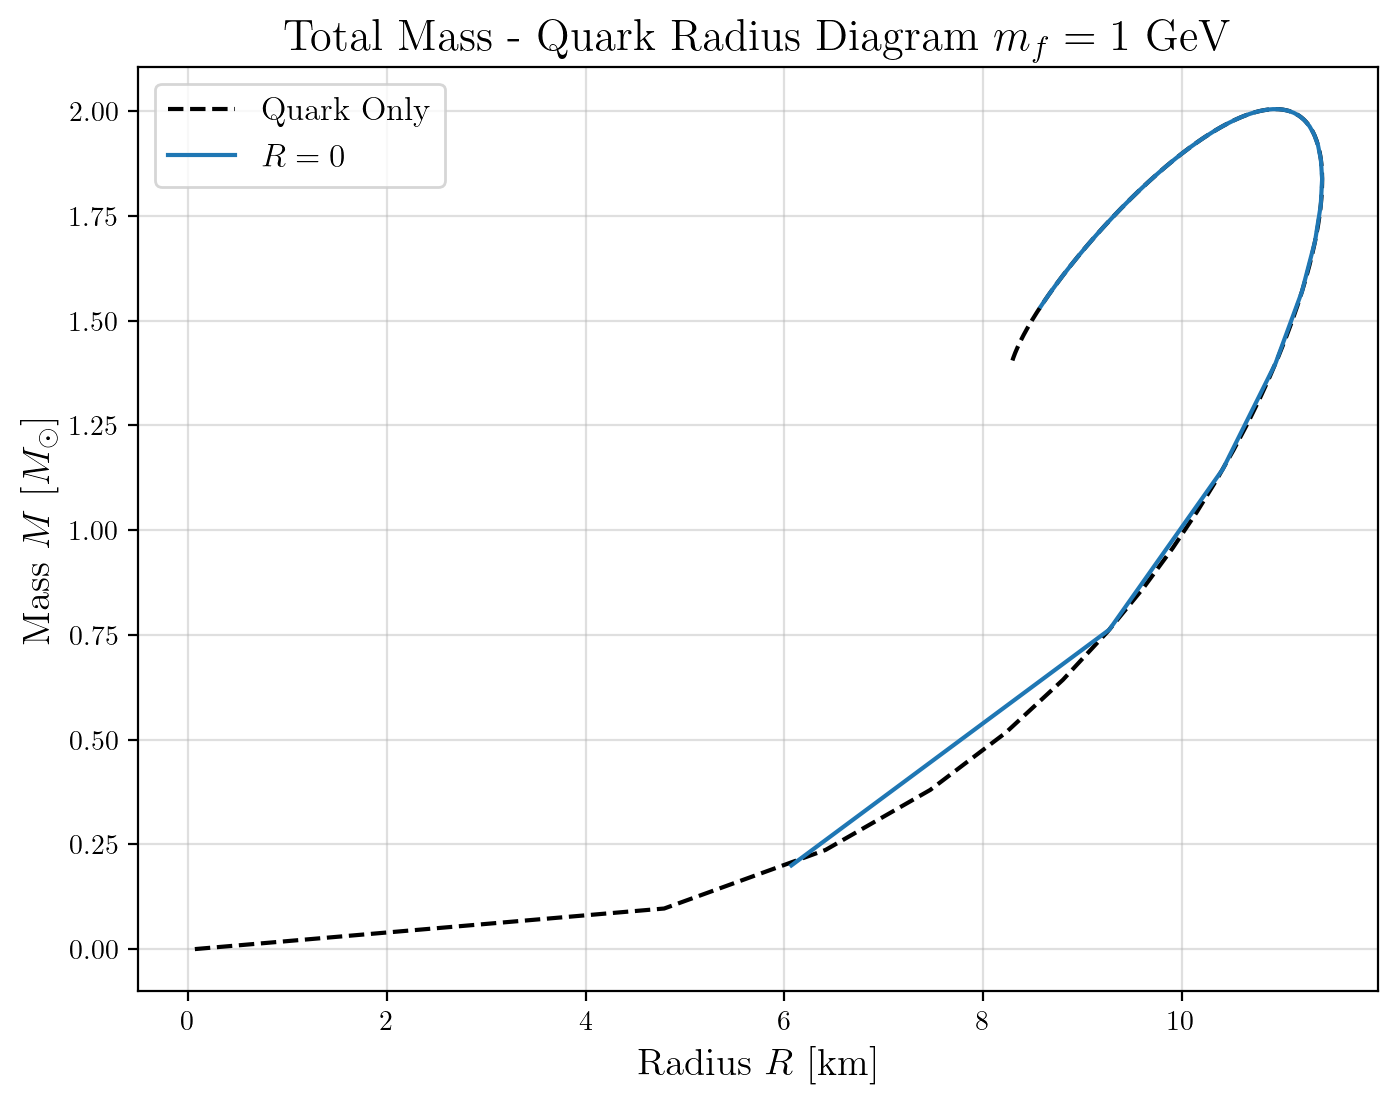

In [24]:
#plot Mass-Radius Diagram
plt.figure(figsize=(8,6))
Mass_radius_Quark = pd.read_csv('../Data/MR_Quark_B145.csv')
radi = Mass_radius_Quark['R'] * factor_R_to_km
mass = Mass_radius_Quark['M'] * factor_M_to_Solar

plt.plot(radi, mass, label='Quark Only', color='black', linestyle='--')

plt.plot(list_Rqm_0, list_M_0, label=r'$R = 0$')
#plt.plot(list_Rqm_1, list_M_1, label=r'$R = 1$')
#plt.plot(list_Rqm_1e_6, list_M_1e_6, label=r'$R = 1 \times 10^{-6}$')
#plt.plot(list_Rqm_100, list_M_100, label=r'$R = 100$')

plt.xlabel(r'Radius $R$ [km]', fontsize=14)
plt.ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
plt.title('Total Mass - Quark Radius Diagram $m_f =1 $ GeV', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

$R=0$ and $R=1e-6$ give the same results.


# Fermion mass 100 GeV

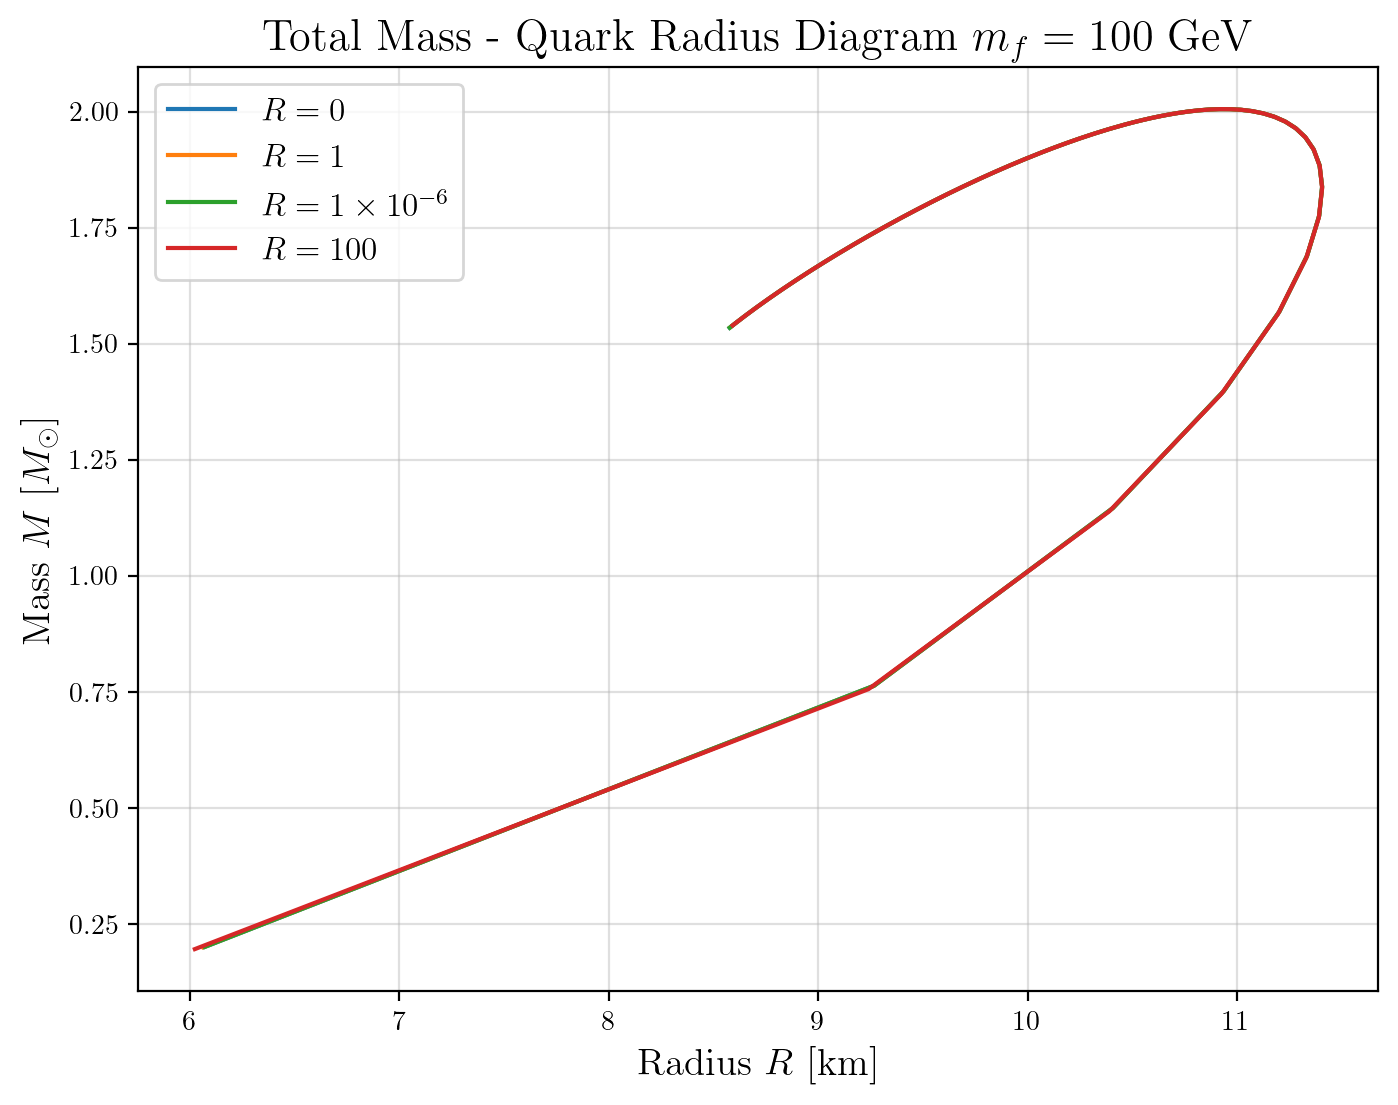

In [25]:
data = pd.read_csv('../Data/EOS_DM_mf1e5.csv')

# Extract columns
grid_e_dm = data['e']
grid_p_dm = data['p']


central_energy_densities_phys = np.linspace(250,1e4,200) # MeV/fm^3

central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_quark, grid_p_quark)

list_Rqm_1e_6_100 = []
list_Rdm_1e_6_100 = []
list_M_1e_6_100 = []
list_Mqm_1e_6_100 = []
list_Mdm_1e_6_100 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=1e-6)
    list_Rqm_1e_6_100.append(data['R_quark'])
    list_Rdm_1e_6_100.append(data['R_dm'])
    list_M_1e_6_100.append(data['M_total'])
    list_Mqm_1e_6_100.append(data['M_quark'])
    list_Mdm_1e_6_100.append(data['M_dm'])


list_Rqm_1_100 = []
list_Rdm_1_100 = []
list_M_1_100 = []
list_Mqm_1_100 = []
list_Mdm_1_100 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=1)
    list_Rqm_1_100.append(data['R_quark'])
    list_Rdm_1_100.append(data['R_dm'])
    list_M_1_100.append(data['M_total'])
    list_Mqm_1_100.append(data['M_quark'])
    list_Mdm_1_100.append(data['M_dm'])


list_Rqm_100_100 = []
list_Rdm_100_100 = []
list_M_100_100 = []
list_Mqm_100_100 = []
list_Mdm_100_100 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=100)
    list_Rqm_100_100.append(data['R_quark'])
    list_Rdm_100_100.append(data['R_dm'])
    list_M_100_100.append(data['M_total'])
    list_Mqm_100_100.append(data['M_quark'])
    list_Mdm_100_100.append(data['M_dm'])



list_Rqm_0_100 = []
list_Rdm_0_100 = []
list_M_0_100 = []
list_Mqm_0_100 = []
list_Mdm_0_100 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=0)
    list_Rqm_0_100.append(data['R_quark'])
    list_Rdm_0_100.append(data['R_dm'])
    list_M_0_100.append(data['M_total'])
    list_Mqm_0_100.append(data['M_quark'])
    list_Mdm_0_100.append(data['M_dm'])



plt.figure(figsize=(8,6))

plt.plot(list_Rqm_0_100, list_M_0_100, label=r'$R = 0$')
plt.plot(list_Rqm_1_100, list_M_1_100, label=r'$R = 1$')
plt.plot(list_Rqm_1e_6_100, list_M_1e_6_100, label=r'$R = 1 \times 10^{-6}$')
plt.plot(list_Rqm_100_100, list_M_100_100, label=r'$R = 100$')

plt.xlabel(r'Radius $R$ [km]', fontsize=14)
plt.ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
plt.title('Total Mass - Quark Radius Diagram $m_f =100 $ GeV', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

When the fermion mass is that high, there is almost non difference, because it stays in the core and doesnt affect as much the rest of the star. lets see the difference with the DM radius for both masses

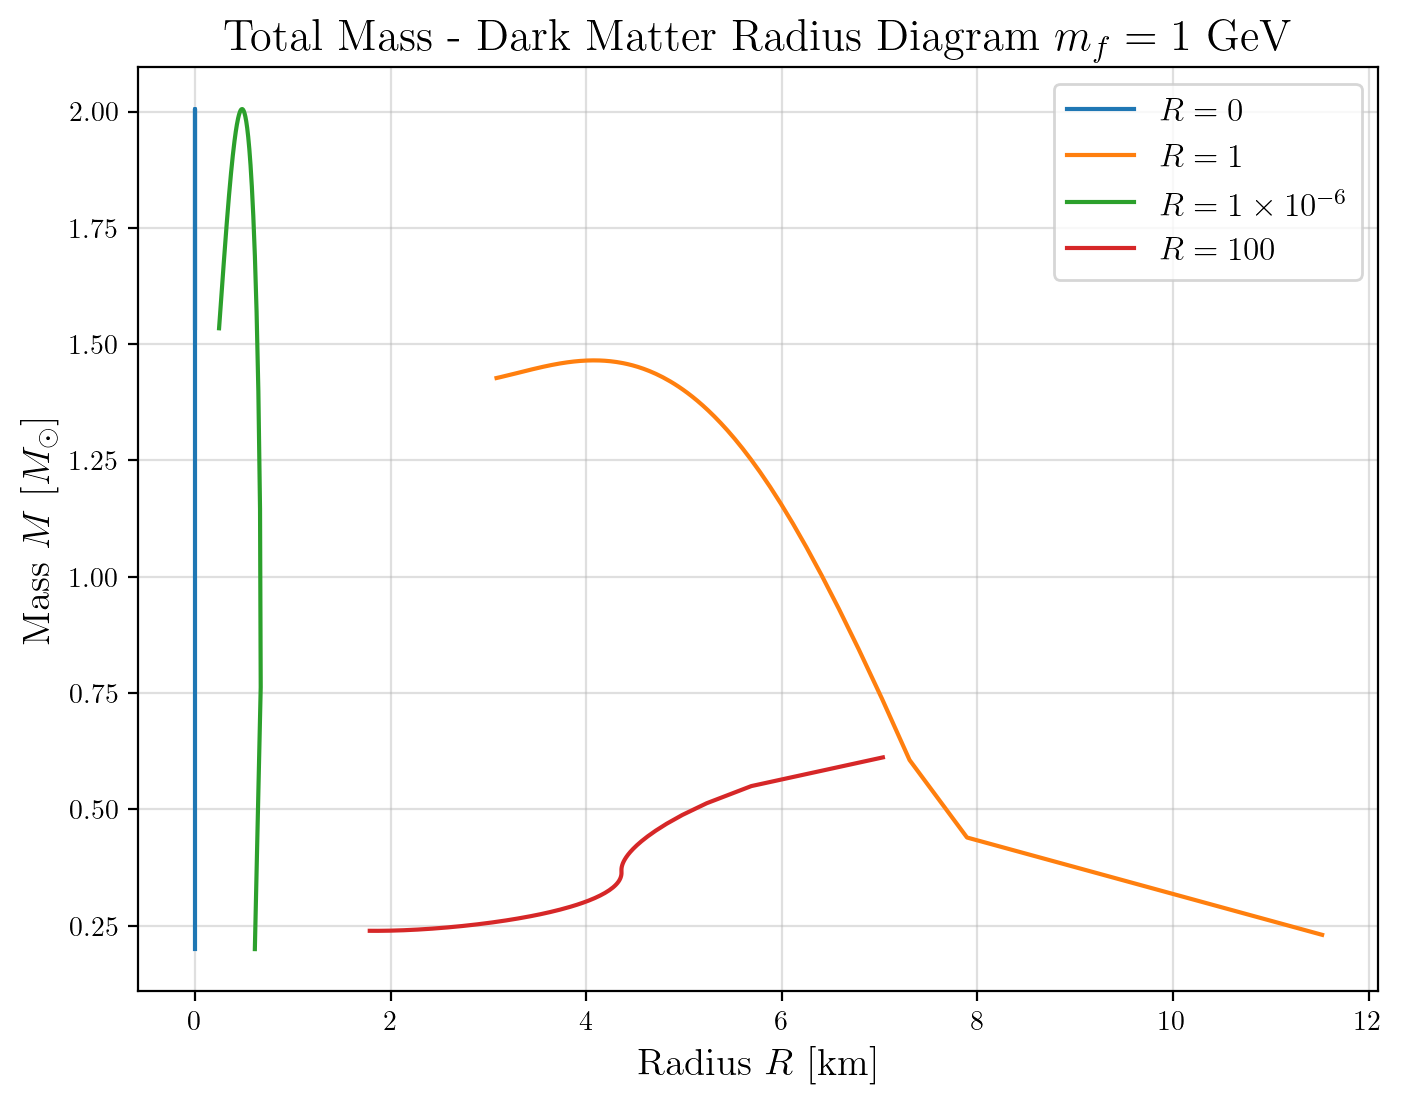

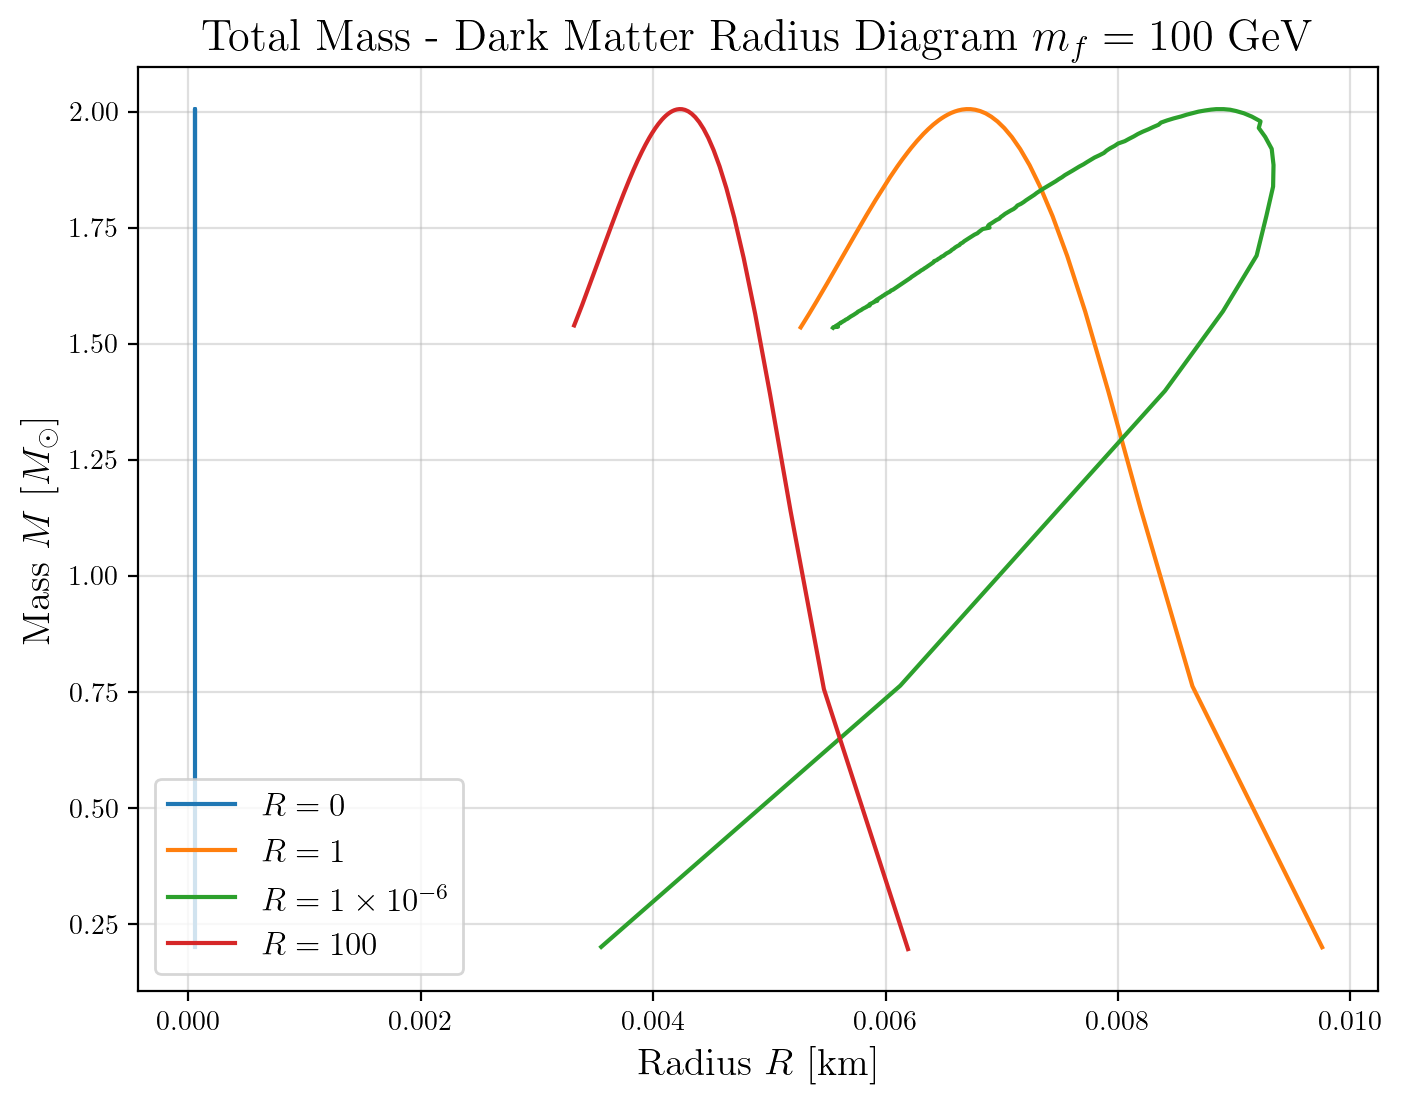

In [26]:
plt.figure(figsize=(8,6))

plt.plot(list_Rdm_0, list_M_0, label=r'$R = 0$')
plt.plot(list_Rdm_1, list_M_1, label=r'$R = 1$')
plt.plot(list_Rdm_1e_6, list_M_1e_6, label=r'$R = 1 \times 10^{-6}$')
plt.plot(list_Rdm_100, list_M_100, label=r'$R = 100$')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'Radius $R$ [km]', fontsize=14)
plt.ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
plt.title('Total Mass - Dark Matter Radius Diagram $m_f =1 $ GeV', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

plt.figure(figsize=(8,6))

plt.plot(list_Rdm_0_100, list_M_0_100, label=r'$R = 0$')
plt.plot(list_Rdm_1_100, list_M_1_100, label=r'$R = 1$')
plt.plot(list_Rdm_1e_6_100, list_M_1e_6_100, label=r'$R = 1 \times 10^{-6}$')
plt.plot(list_Rdm_100_100, list_M_100_100, label=r'$R = 100$')

plt.xlabel(r'Radius $R$ [km]', fontsize=14)
plt.ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
plt.title('Total Mass - Dark Matter Radius Diagram $m_f =100 $ GeV', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

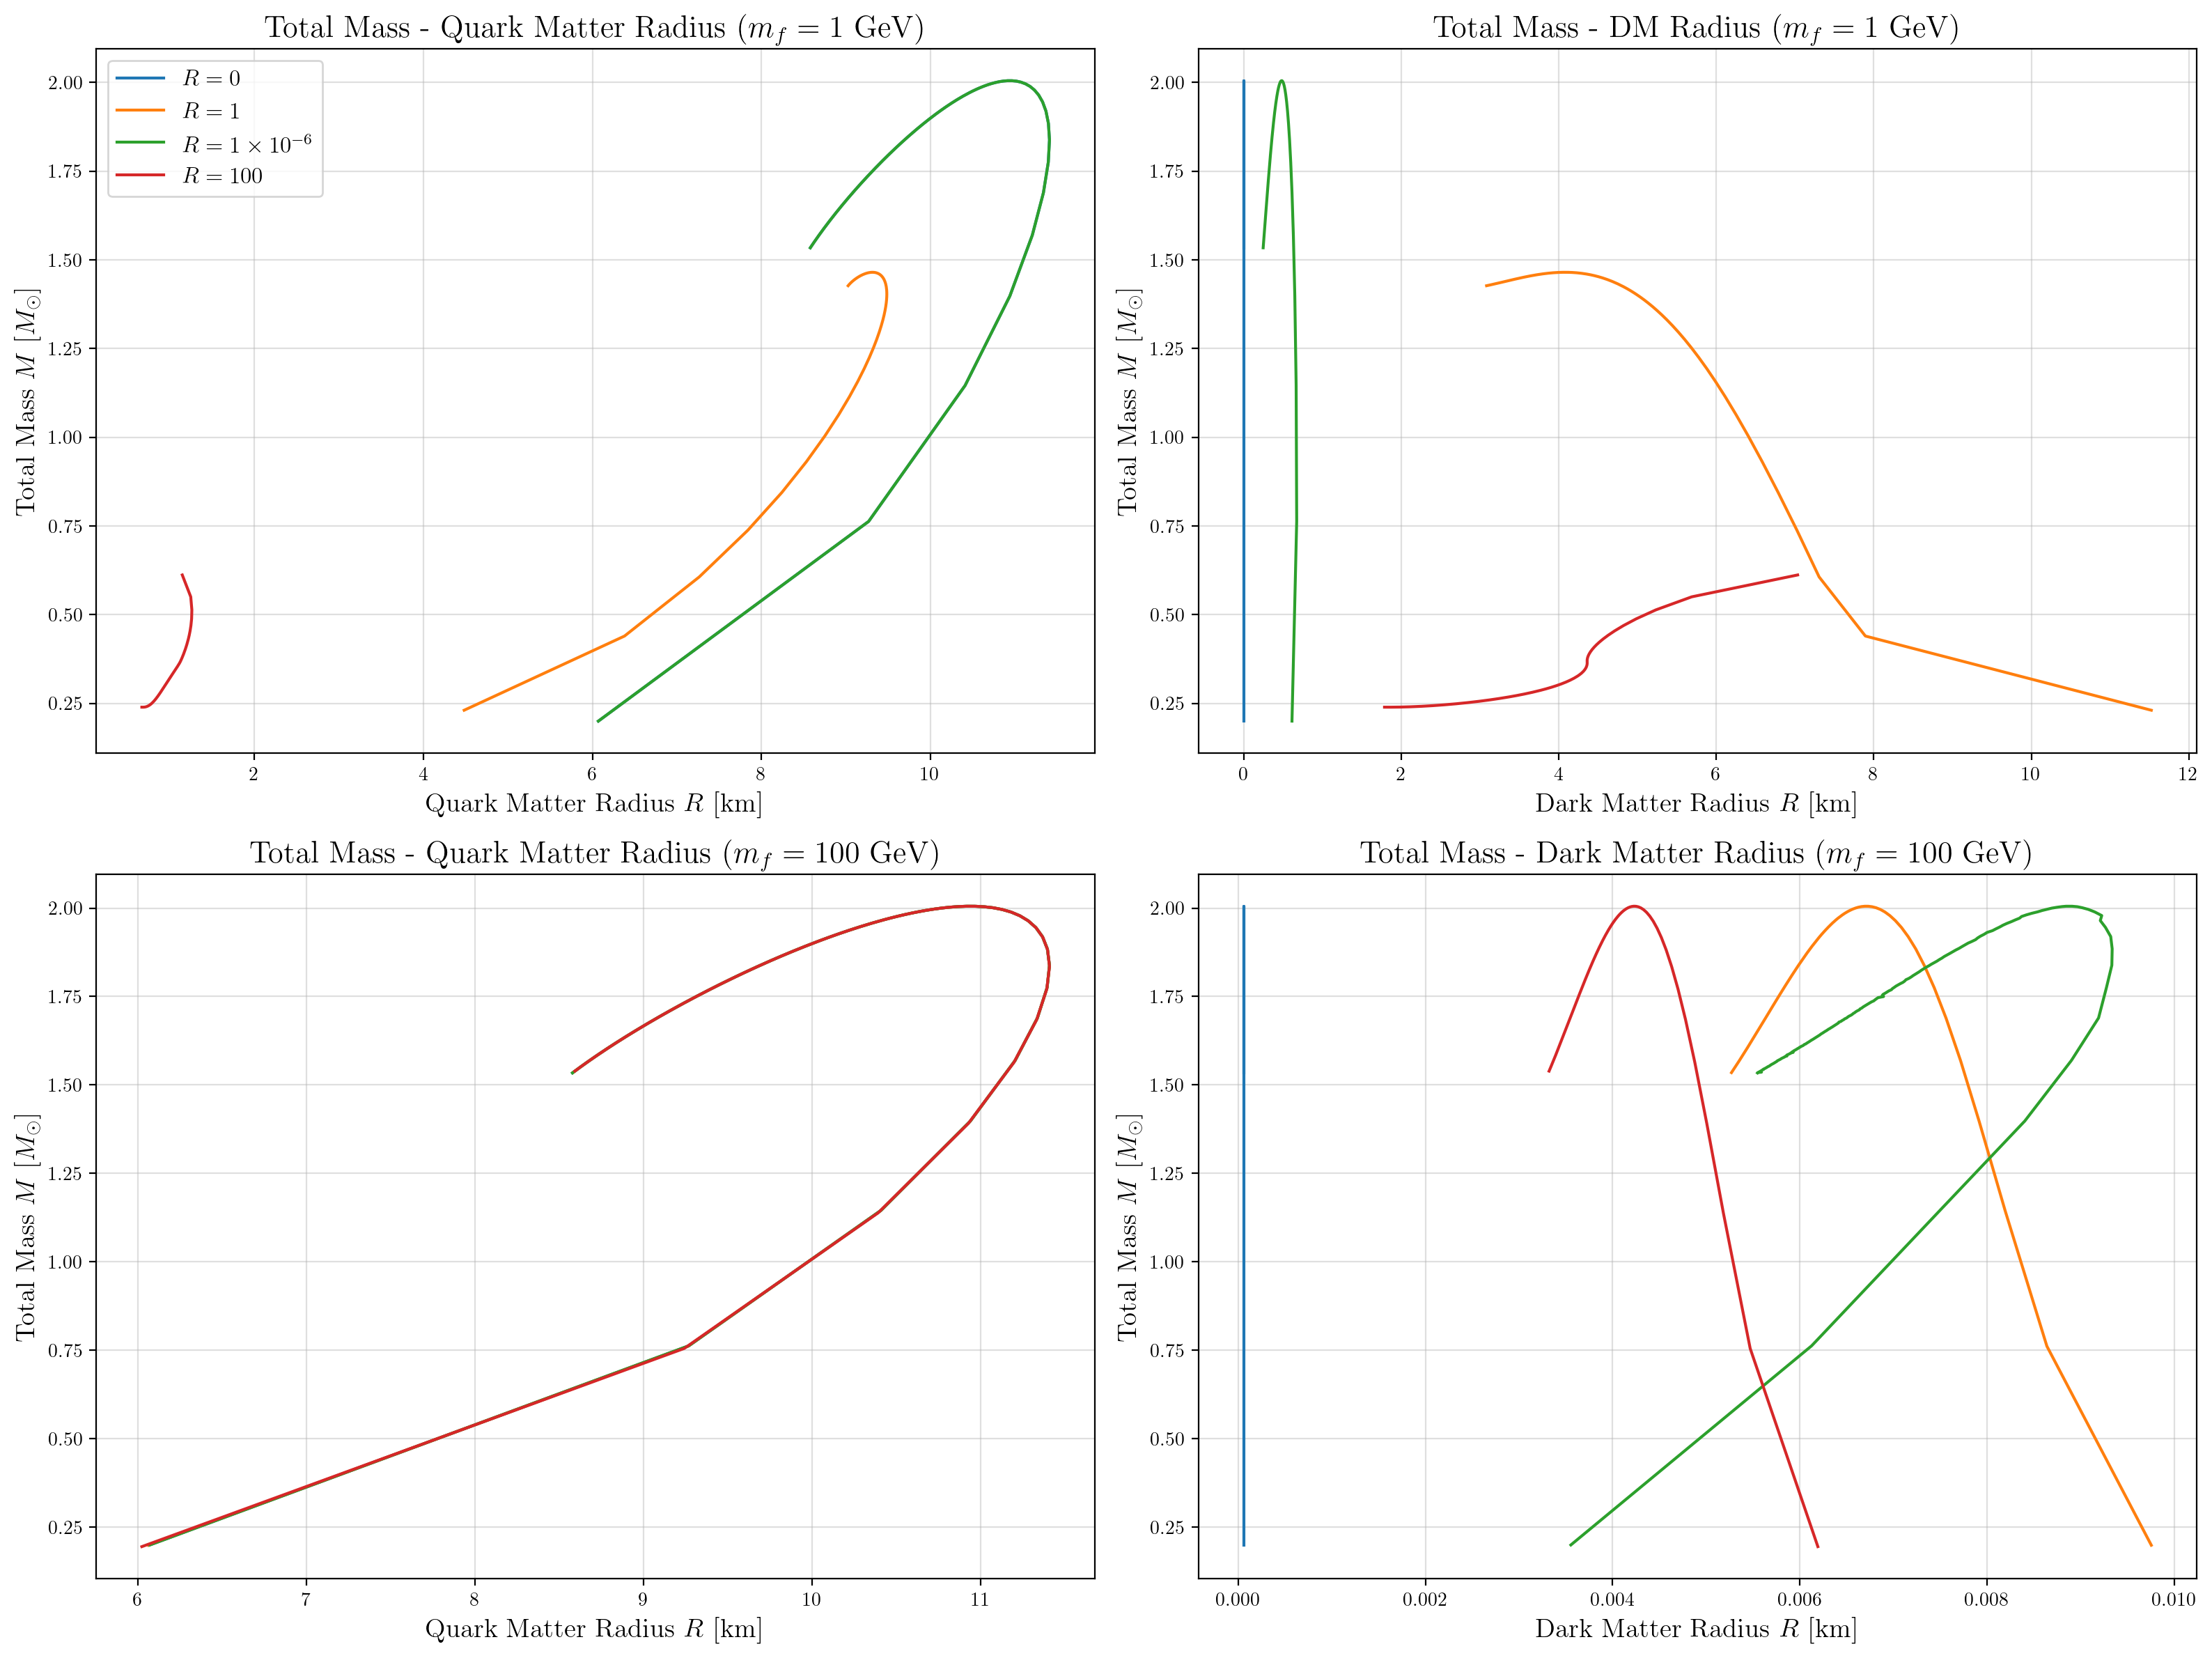

In [27]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns
# Increase figsize so the 4 plots have enough room
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# --- Plot 1: Quark Radius (mf = 1 GeV) ---
# Location: Top Left [0, 0]
axs[0, 0].plot(list_Rqm_0, list_M_0, label=r'$R = 0$')
axs[0, 0].plot(list_Rqm_1, list_M_1, label=r'$R = 1$')
axs[0, 0].plot(list_Rqm_1e_6, list_M_1e_6, label=r'$R = 1 \times 10^{-6}$')
axs[0, 0].plot(list_Rqm_100, list_M_100, label=r'$R = 100$')
axs[0, 0].set_xlabel(r' Quark Matter Radius $R$ [km]', fontsize=14)
axs[0, 0].set_ylabel(r'Total Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[0, 0].set_title(r'Total Mass - Quark Matter Radius ($m_f =1$ GeV)', fontsize=16)
axs[0, 0].legend(fontsize=12)
axs[0, 0].grid(True)



# --- Plot 2: DM Radius (mf = 1 GeV) ---
# Location: Bottom Left [1, 0]
axs[0, 1].plot(list_Rdm_0, list_M_0, label=r'$R = 0$')
axs[0, 1].plot(list_Rdm_1, list_M_1, label=r'$R = 1$')
axs[0, 1].plot(list_Rdm_1e_6, list_M_1e_6, label=r'$R = 1 \times 10^{-6}$')
axs[0, 1].plot(list_Rdm_100, list_M_100, label=r'$R = 100$')
axs[0, 1].set_xlabel(r' Dark Matter Radius $R$ [km]', fontsize=14)
axs[0, 1].set_ylabel(r' Total Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[0, 1].set_title(r'Total Mass - DM Radius ($m_f =1$ GeV)', fontsize=16)
#axs[0, 1].legend(fontsize=12)
axs[0, 1].grid(True)


# --- Plot 3: Quark Radius (mf = 100 GeV) ---
# Location: Top Right [0, 1]
axs[1, 0].plot(list_Rqm_0_100, list_M_0_100, label=r'$R = 0$')
axs[1, 0].plot(list_Rqm_1_100, list_M_1_100, label=r'$R = 1$')
axs[1, 0].plot(list_Rqm_1e_6_100, list_M_1e_6_100, label=r'$R = 1 \times 10^{-6}$')
axs[1, 0].plot(list_Rqm_100_100, list_M_100_100, label=r'$R = 100$')
axs[1, 0].set_xlabel(r'Quark Matter Radius $R$ [km]', fontsize=14)
axs[1, 0].set_ylabel(r'Total Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[1, 0].set_title(r'Total Mass - Quark Matter Radius ($m_f =100$ GeV)', fontsize=16)
#axs[1, 0].legend(fontsize=12)
axs[1, 0].grid(True)

# --- Plot 4: DM Radius (mf = 100 GeV) ---
# Location: Bottom Right [1, 1]
axs[1, 1].plot(list_Rdm_0_100, list_M_0_100, label=r'$R = 0$')
axs[1, 1].plot(list_Rdm_1_100, list_M_1_100, label=r'$R = 1$')
axs[1, 1].plot(list_Rdm_1e_6_100, list_M_1e_6_100, label=r'$R = 1 \times 10^{-6}$')
axs[1, 1].plot(list_Rdm_100_100, list_M_100_100, label=r'$R = 100$')
axs[1, 1].set_xlabel(r'Dark Matter Radius $R$ [km]', fontsize=14)
axs[1, 1].set_ylabel(r'Total Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[1, 1].set_title(r'Total Mass - Dark Matter Radius ($m_f =100$ GeV)', fontsize=16)
#axs[1, 1].legend(fontsize=12)
axs[1, 1].grid(True)

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()

In [39]:
# find maximum of total mass, and the corresponding quark and dm aportation

total_mass_0 = np.max(list_M_0)
index = np.argmax(list_M_0)
quark_mass_0 = list_Mqm_0[index]
dm_mass_0 = list_Mdm_0[index]
dm_prop_0 = dm_mass_0 / total_mass_0


total_mass_1 = np.max(list_M_1)
index = np.argmax(list_M_1)
quark_mass_1 = list_Mqm_1[index]
dm_mass_1 = list_Mdm_1[index]
dm_prop_1 = dm_mass_1 / total_mass_1

total_mass_1e_6 = np.max(list_M_1e_6)
index = np.argmax(list_M_1e_6)
quark_mass_1e_6 = list_Mqm_1e_6[index]
dm_mass_1e_6 = list_Mdm_1e_6[index]
dm_prop_1e_6 = dm_mass_1e_6 / total_mass_1e_6

total_mass_100 = np.max(list_M_100)
index = np.argmax(list_M_100)
quark_mass_100 = list_Mqm_100[index]
dm_mass_100 = list_Mdm_100[index]
dm_prop_100 = dm_mass_100 / total_mass_100

total_mass_0_100 = np.max(list_M_0_100)
index = np.argmax(list_M_0_100)
quark_mass_0_100 = list_Mqm_0_100[index]
dm_mass_0_100 = list_Mdm_0_100[index]
dm_prop_0_100 = dm_mass_0_100 / total_mass_0_100

total_mass_1_100 = np.max(list_M_1_100)
index = np.argmax(list_M_1_100)
quark_mass_1_100 = list_Mqm_1_100[index]
dm_mass_1_100 = list_Mdm_1_100[index]
dm_prop_1_100 = dm_mass_1_100 / total_mass_1_100

total_mass_1e_6_100 = np.max(list_M_1e_6_100)
index = np.argmax(list_M_1e_6_100)
quark_mass_1e_6_100 = list_Mqm_1e_6_100[index]
dm_mass_1e_6_100 = list_Mdm_1e_6_100[index]
dm_prop_1e_6_100 = dm_mass_1e_6_100 / total_mass_1e_6_100

total_mass_100_100 = np.max(list_M_100_100)
index = np.argmax(list_M_100_100)
quark_mass_100_100 = list_Mqm_100_100[index]
dm_mass_100_100 = list_Mdm_100_100[index]
dm_prop_100_100 = dm_mass_100_100 / total_mass_100_100

#plot the information of maximum masses and dm proportion
print("mf = 1 GeV")
print(f"R=0:    M_total = {total_mass_0:.4e} M_sun, M_quark = {quark_mass_0:.4e} M_sun, M_dm = {dm_mass_0:.4e} M_sun, DM proportion = {dm_prop_0:.4e}")
print(f"R=1e-6: M_total = {total_mass_1e_6:.4e} M_sun, M_quark = {quark_mass_1e_6:.4e} M_sun, M_dm = {dm_mass_1e_6:.4e} M_sun, DM proportion = {dm_prop_1e_6:.4e}")
print(f"R=1:    M_total = {total_mass_1:.4e} M_sun, M_quark = {quark_mass_1:.4e} M_sun, M_dm = {dm_mass_1:.4e} M_sun, DM proportion = {dm_prop_1:.4e}")    
print(f"R=100:  M_total = {total_mass_100:.4e} M_sun, M_quark = {quark_mass_100:.4e} M_sun, M_dm = {dm_mass_100:.4e} M_sun, DM proportion = {dm_prop_100:.4e}")
print()
print("mf = 100 GeV")
print(f"R=0:    M_total = {total_mass_0_100:.4e} M_sun, M_quark = {quark_mass_0_100:.4e} M_sun, M_dm = {dm_mass_0_100:.4e} M_sun, DM proportion = {dm_prop_0_100:.4e}")
print(f"R=1e-6: M_total = {total_mass_1e_6_100:.4e} M_sun, M_quark = {quark_mass_1e_6_100:.4e} M_sun, M_dm = {dm_mass_1e_6_100:.4e} M_sun, DM proportion = {dm_prop_1e_6_100:.4e}")
print(f"R=1:    M_total = {total_mass_1_100:.4e} M_sun, M_quark = {quark_mass_1_100:.4e} M_sun, M_dm = {dm_mass_1_100:.4e} M_sun, DM proportion = {dm_prop_1_100:.4e}")    
print(f"R=100:  M_total = {total_mass_100_100:.4e} M_sun, M_quark = {quark_mass_100_100:.4e} M_sun, M_dm = {dm_mass_100_100:.4e} M_sun, DM proportion = {dm_prop_100_100:.4e}")

mf = 1 GeV
R=0:    M_total = 2.0052e+00 M_sun, M_quark = 2.0052e+00 M_sun, M_dm = 2.2630e-24 M_sun, DM proportion = 1.1286e-24
R=1e-6: M_total = 2.0052e+00 M_sun, M_quark = 2.0052e+00 M_sun, M_dm = 7.0608e-08 M_sun, DM proportion = 3.5212e-08
R=1:    M_total = 1.4651e+00 M_sun, M_quark = 1.2308e+00 M_sun, M_dm = 2.3433e-01 M_sun, DM proportion = 1.5994e-01
R=100:  M_total = 6.1181e-01 M_sun, M_quark = 1.3520e-03 M_sun, M_dm = 6.1046e-01 M_sun, DM proportion = 9.9779e-01

mf = 100 GeV
R=0:    M_total = 2.0052e+00 M_sun, M_quark = 2.0052e+00 M_sun, M_dm = 2.2630e-16 M_sun, DM proportion = 1.1286e-16
R=1e-6: M_total = 2.0052e+00 M_sun, M_quark = 2.0052e+00 M_sun, M_dm = 1.1535e-09 M_sun, DM proportion = 5.7523e-10
R=1:    M_total = 2.0052e+00 M_sun, M_quark = 2.0052e+00 M_sun, M_dm = 6.9183e-07 M_sun, DM proportion = 3.4501e-07
R=100:  M_total = 2.0053e+00 M_sun, M_quark = 2.0053e+00 M_sun, M_dm = 2.7454e-06 M_sun, DM proportion = 1.3691e-06


To check the validity of this code, i will use Mikel EoS grid and see if i obtain the same results